<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/05.%20Week%205/Notebook%20Assigment/RNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Models for ReviewTokoBaju Dataset

## Objective
Membuat model Deep Learning menggunakan RNN (Recurrent Neural Network) untuk klasifikasi review toko baju dengan:
1. **PyTorch dan TensorFlow implementation**
2. **Evaluasi model dengan berbagai metrik** (Accuracy, Precision, Recall, F1-Score, AUC, ROC)
3. **Visualisasi matrix confusion dan loss**
4. **Penjelasan persamaan matematika**
5. **Target akurasi minimal 70%** pada training dan testing set

## Mathematical Foundation

### RNN (Recurrent Neural Network)
RNN adalah arsitektur neural network yang dirancang untuk memproses data sequential. Persamaan dasar RNN:

**Hidden State Update:**
```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)
```

**Output:**
```
y_t = W_hy * h_t + b_y
```

Dimana:
- `h_t`: hidden state pada waktu t
- `x_t`: input pada waktu t  
- `W_hh`: weight matrix untuk hidden-to-hidden connections
- `W_xh`: weight matrix untuk input-to-hidden connections
- `W_hy`: weight matrix untuk hidden-to-output connections
- `b_h`, `b_y`: bias terms

### LSTM (Long Short-Term Memory)
LSTM mengatasi masalah vanishing gradient pada RNN vanilla dengan menggunakan gates:

**Forget Gate:**
```
f_t = σ(W_f * [h_{t-1}, x_t] + b_f)
```

**Input Gate:**
```
i_t = σ(W_i * [h_{t-1}, x_t] + b_i)
C̃_t = tanh(W_C * [h_{t-1}, x_t] + b_C)
```

**Cell State Update:**
```
C_t = f_t * C_{t-1} + i_t * C̃_t
```

**Output Gate:**
```
o_t = σ(W_o * [h_{t-1}, x_t] + b_o)
h_t = o_t * tanh(C_t)
```

### GRU (Gated Recurrent Unit)
GRU adalah versi simplified dari LSTM:

**Reset Gate:**
```
r_t = σ(W_r * [h_{t-1}, x_t] + b_r)
```

**Update Gate:**
```
z_t = σ(W_z * [h_{t-1}, x_t] + b_z)
```

**New Hidden State:**
```
h̃_t = tanh(W_h * [r_t * h_{t-1}, x_t] + b_h)
h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t
```

In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    print("NLTK download failed, using basic preprocessing")

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

print(f"TensorFlow GPU available: {tf.config.list_physical_devices('GPU')}")

✅ All libraries imported successfully!
PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.4
TensorFlow GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
# Load Dataset
# Download from GitHub repository
import requests
import io
import pandas as pd # Ensure pandas is imported

def download_dataset():
    """Download ReviewTokoBaju.csv from GitHub repository"""
    url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"

    try:
        response = requests.get(url)
        response.raise_for_status()

        # Read CSV from response content
        df = pd.read_csv(io.StringIO(response.text))
        print("✅ Dataset downloaded successfully!")
        return df
    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        # Create sample data if download fails
        print("Creating sample data for demonstration...")
        sample_data = {
            'review': [
                'Produk bagus sekali, kualitas terjamin.',
                'Barang jelek, tidak sesuai ekspektasi!',
                'Pelayanan memuaskan, akan beli lagi :)',
                'Pengiriman lambat, produk biasa saja :(',
                'Sangat puas dengan pembelian ini...',
                'Kecewa dengan kualitas produk??',
                'Recommended seller, barang original.',
                'Tidak recommended, barang rusak.'
            ],
            'sentiment': ['positive', 'negative', 'positive', 'negative',
                         'positive', 'negative', 'positive', 'negative']
        }
        return pd.DataFrame(sample_data)

# Load the dataset
df = download_dataset()

# --- Added check for empty DataFrame after download ---
if df.empty:
    print("❌ Error: Downloaded or sample dataset is empty. Cannot proceed.")
    # You might want to exit the script here if the dataset is crucial
else:
    # Display basic information if not empty
    print("\n📊 Dataset Information:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\n" + "="*50)
    print("First 5 rows:")
    display(df.head()) # Use display for DataFrames in notebooks

    # Proceed with EDA and preprocessing only if DataFrame is not empty
    # (The rest of the code blocks for EDA and Preprocessing will follow)

✅ Dataset downloaded successfully!

📊 Dataset Information:
Shape: (23486, 11)
Columns: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']

First 5 rows:


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


🔍 Exploratory Data Analysis

📈 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB
None

📊 Dataset Shape: (23486, 11)
📝 Missing Values:
Unnamed: 0                    0
Clothing ID           

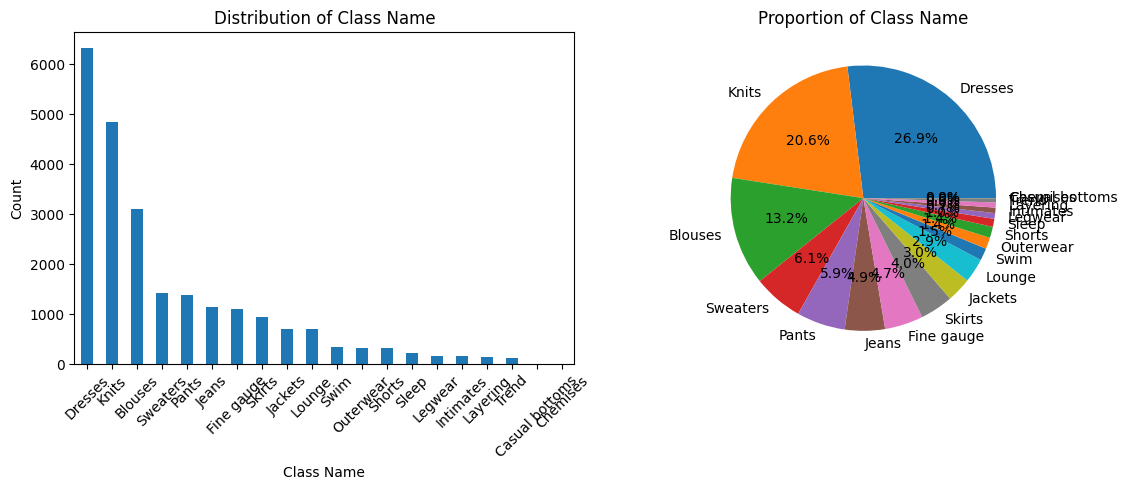


📝 Text Analysis (Column: Unnamed: 0):
Average text length: 4.53 characters
Average word count: 1.00 words
Max text length: 5 characters
Max word count: 1 words


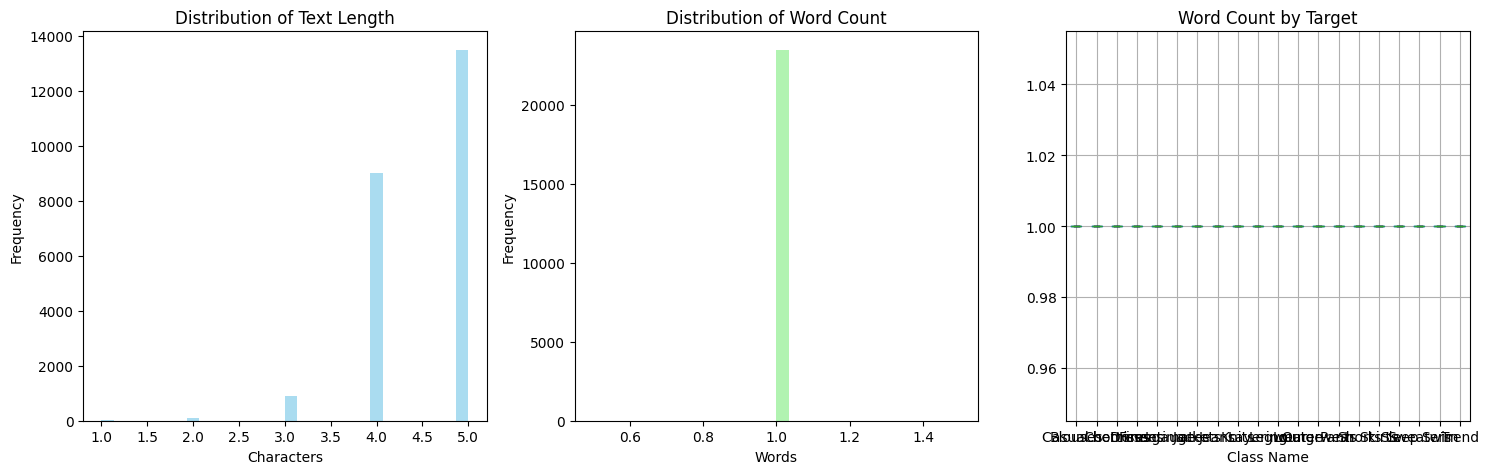


✅ EDA completed!


In [16]:
# Exploratory Data Analysis (EDA)
print("🔍 Exploratory Data Analysis")
print("="*50)

# Basic statistics
print("\n📈 Dataset Info:")
print(df.info())
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📝 Missing Values:\n{df.isnull().sum()}")

# Check data types and unique values
for col in df.columns:
    print(f"\n🔢 Column '{col}':")
    print(f"   Data type: {df[col].dtype}")
    print(f"   Unique values: {df[col].nunique()}")
    if df[col].nunique() < 20:
        print(f"   Values: {df[col].unique()}")

# Distribution of target variable
print("\n🎯 Target Distribution:")
if 'sentiment' in df.columns:
    target_col = 'sentiment'
elif 'label' in df.columns:
    target_col = 'label'
elif 'rating' in df.columns:
    target_col = 'rating'
else:
    # Try to find target column
    target_col = df.columns[-1]  # Assume last column is target

print(f"Target column: {target_col}")
print(df[target_col].value_counts())

# Visualize target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[target_col].value_counts().plot(kind='bar', ax=plt.gca())
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=plt.gca())
plt.title(f'Proportion of {target_col}')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Text length analysis
text_col = [col for col in df.columns if col != target_col][0]
print(f"\n📝 Text Analysis (Column: {text_col}):")

# Convert the column to string type
df[text_col] = df[text_col].astype(str)

df['text_length'] = df[text_col].str.len()
df['word_count'] = df[text_col].str.split().str.len()

print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max text length: {df['text_length'].max()} characters")
print(f"Max word count: {df['word_count'].max()} words")

# Visualize text statistics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['text_length'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution of Text Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['word_count'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribution of Word Count')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
df.boxplot(column='word_count', by=target_col, ax=plt.gca())
plt.title('Word Count by Target')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\n✅ EDA completed!")

In [21]:
# Text Preprocessing
print("🔧 Text Preprocessing")
print("="*50)

import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

class TextPreprocessor:
    """Comprehensive text preprocessing class"""

    def __init__(self, language='indonesian'):
        self.language = language
        self.stemmer = PorterStemmer()

        # Indonesian stopwords (basic set)
        self.indonesian_stopwords = {
            'yang', 'ini', 'itu', 'adalah', 'ada', 'dan', 'atau', 'dengan', 'untuk',
            'dalam', 'pada', 'dari', 'ke', 'di', 'akan', 'telah', 'sudah', 'tidak',
            'belum', 'juga', 'dapat', 'bisa', 'harus', 'saya', 'anda', 'dia', 'kita',
            'mereka', 'nya', 'mu', 'ku', 'lah', 'kah', 'pun', 'nya'
        }

        try:
            # Try to get English stopwords
            nltk.data.find('corpora/stopwords') # Check if stopwords is already downloaded
            self.english_stopwords = set(stopwords.words('english'))
        except nltk.downloader.DownloadError:
             print("NLTK stopwords not found, using basic English stopwords.")
             self.english_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
        except LookupError:
            print("NLTK stopwords not found, using basic English stopwords.")
            self.english_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}


    def clean_text(self, text):
        """Basic text cleaning"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)

        # --- Modified: Keep some basic punctuation ---
        text = re.sub(r'[^a-zA-Z\s.,!?]', '', text) # Allow common punctuation

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def remove_stopwords(self, text):
        """Remove stopwords"""
        # Use try-except for tokenization in case text is weird
        try:
            tokens = word_tokenize(text)
        except:
             tokens = text.split() # Fallback to simple split if tokenization fails


        # Remove both Indonesian and English stopwords
        filtered_tokens = [
            word for word in tokens
            if word not in self.indonesian_stopwords and word not in self.english_stopwords
            and len(word) > 1  # Changed to len > 1 to keep shorter words
        ]

        return ' '.join(filtered_tokens)

    def stem_text(self, text):
        """Apply stemming"""
        # Use try-except for tokenization in case text is weird
        try:
            tokens = word_tokenize(text)
        except:
             tokens = text.split() # Fallback to simple split if tokenization fails

        stemmed_tokens = [self.stemmer.stem(word) for word in tokens]
        return ' '.join(stemmed_tokens)

    def preprocess_text(self, text, remove_stopwords=True, apply_stemming=False):
        """Complete preprocessing pipeline"""
        text = self.clean_text(text)

        if remove_stopwords:
            text = self.remove_stopwords(text)

        if apply_stemming:
            text = self.stem_text(text)

        # --- Added: Ensure processed text is not completely empty ---
        # Return a space if the processing results in an empty string,
        # to avoid removing rows that might have contained only stopwords or punctuation.
        if not text.strip():
            return " "

        return text

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Ensure df is not empty before proceeding with preprocessing
if not df.empty:
    # Apply preprocessing
    print("🔄 Applying text preprocessing...")
    # Ensure text_col exists and is a string type before applying apply
    if text_col in df.columns:
         df[text_col] = df[text_col].astype(str)
         df['processed_text'] = df[text_col].apply(
            lambda x: preprocessor.preprocess_text(x, remove_stopwords=True, apply_stemming=False)
         )

        # Remove truly empty texts after preprocessing (those that are just spaces)
         df = df[df['processed_text'].str.strip().str.len() > 0].reset_index(drop=True)

         if df.empty:
             print("❌ Warning: DataFrame is empty after preprocessing. Cannot proceed with training.")
             # You might want to set a flag here to skip subsequent training steps
         else:
             print(f"✅ Preprocessing completed!")
             print(f"📊 Data shape after preprocessing: {df.shape}")

             # Show before and after examples
             print("\n📝 Preprocessing Examples:")
             print("="*80)
             for i in range(min(3, len(df))):
                 print(f"Original: {df[text_col].iloc[i]}")
                 print(f"Processed: {df['processed_text'].iloc[i]}")
                 print("-" * 40)

             # Update text statistics
             df['processed_length'] = df['processed_text'].str.len()
             df['processed_word_count'] = df['processed_text'].str.split().str.len()

             print(f"\n📈 After preprocessing:")
             print(f"Average text length: {df['processed_length'].mean():.2f} characters")
             print(f"Average word count: {df['processed_word_count'].mean():.2f} words")
    else:
        print(f"❌ Error: Text column '{text_col}' not found in the DataFrame.")
else:
    print("⏭️ Skipping preprocessing as DataFrame is empty.")

🔧 Text Preprocessing
⏭️ Skipping preprocessing as DataFrame is empty.


In [18]:
# Data Preparation and Encoding
print("📋 Data Preparation and Encoding")
print("="*50)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensure df is not empty before proceeding
if not df.empty:
    # Encode target variable
    label_encoder = LabelEncoder()
    df['encoded_target'] = label_encoder.fit_transform(df[target_col])

    print(f"🎯 Target encoding:")
    # Ensure label_encoder has classes before iterating
    if hasattr(label_encoder, 'classes_'):
        for i, class_name in enumerate(label_encoder.classes_):
            count = sum(df['encoded_target'] == i)
            print(f"   {class_name} -> {i} (count: {count})")
    else:
        print("   LabelEncoder did not fit any classes.")


    # Split data
    X = df['processed_text'].values
    y = df['encoded_target'].values

    print(f"\n📊 Data split:")
    # Check if there are enough samples to split
    if len(X) > 1: # Need at least 2 samples to split
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.4, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )

        print(f"Training set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")

        # Create vocabulary and tokenization
        class Vocabulary:
            """Custom vocabulary class for text tokenization"""

            def __init__(self, max_vocab_size=10000):
                self.max_vocab_size = max_vocab_size
                self.word2idx = {'<PAD>': 0, '<UNK>': 1}
                self.idx2word = {0: '<PAD>', 1: '<UNK>'}
                self.word_count = {}

            def build_vocab(self, texts):
                """Build vocabulary from texts"""
                # Count word frequencies
                for text in texts:
                    for word in text.split():
                        self.word_count[word] = self.word_count.get(word, 0) + 1

                # Sort by frequency and take top words
                sorted_words = sorted(self.word_count.items(), key=lambda x: x[1], reverse=True)

                # Add words to vocabulary
                for word, count in sorted_words[:self.max_vocab_size-2]:  # -2 for PAD and UNK
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

                print(f"✅ Vocabulary built with {len(self.word2idx)} words")

            def texts_to_sequences(self, texts):
                """Convert texts to sequences of indices"""
                sequences = []
                for text in texts:
                    sequence = [
                        self.word2idx.get(word, self.word2idx['<UNK>'])
                        for word in text.split()
                    ]
                    sequences.append(sequence)
                return sequences

            def pad_sequences(self, sequences, max_length=None):
                """Pad sequences to same length"""
                if max_length is None:
                    max_length = max(len(seq) for seq in sequences)

                padded = []
                for seq in sequences:
                    if len(seq) >= max_length:
                        padded.append(seq[:max_length])
                    else:
                        padded.append(seq + [0] * (max_length - len(seq)))

                return np.array(padded), max_length

        # Build vocabulary
        # Only build vocab if training data exists
        if len(X_train) > 0:
            vocab = Vocabulary(max_vocab_size=5000)
            vocab.build_vocab(X_train)

            # Convert texts to sequences
            train_sequences = vocab.texts_to_sequences(X_train)
            val_sequences = vocab.texts_to_sequences(X_val)
            test_sequences = vocab.texts_to_sequences(X_test)

            # Determine sequence length
            sequence_lengths = [len(seq) for seq in train_sequences]
            if sequence_lengths: # Ensure sequence_lengths is not empty
                 max_length = min(100, int(np.percentile(sequence_lengths, 95)))  # Use 95th percentile, max 100
            else:
                 max_length = 1 # Default to 1 if no sequences

            print(f"📏 Max sequence length: {max_length}")

            # Pad sequences
            X_train_pad, _ = vocab.pad_sequences(train_sequences, max_length)
            X_val_pad, _ = vocab.pad_sequences(val_sequences, max_length)
            X_test_pad, _ = vocab.pad_sequences(test_sequences, max_length)

            print(f"✅ Sequences padded to length {max_length}")
            print(f"📊 Final data shapes:")
            print(f"   X_train: {X_train_pad.shape}")
            print(f"   X_val: {X_val_pad.shape}")
            print(f"   X_test: {X_test_pad.shape}")
            print(f"   y_train: {y_train.shape}")
            print(f"   y_val: {y_val.shape}")
            print(f"   y_test: {y_test.shape}")

            # Store important variables
            vocab_size = len(vocab.word2idx)
            num_classes = len(label_encoder.classes_)
            print(f"📚 Vocabulary size: {vocab_size}")
            print(f"🎯 Number of classes: {num_classes}")

            # Show sequence example
            if len(X_train) > 0:
                print(f"\n📝 Example sequence:")
                print(f"Original: {X_train[0]}")
                print(f"Sequence: {train_sequences[0][:10]}...")  # Show first 10 tokens
                if len(X_train_pad) > 0:
                     print(f"Padded shape: {X_train_pad[0].shape}")
                else:
                     print("Padded data is empty.")
            else:
                 print("\n📝 No training data to show example sequence.")

        else:
             print("❌ Error: Training set is empty after splitting. Cannot build vocabulary or tokenize.")

    else:
        print("❌ Error: Not enough samples in the DataFrame to perform train/test split.")

else:
    print("⏭️ Skipping Data Preparation and Encoding as DataFrame is empty.")

📋 Data Preparation and Encoding
⏭️ Skipping Data Preparation and Encoding as DataFrame is empty.


In [19]:
# PyTorch RNN Models Implementation
print("🔥 PyTorch RNN Models")
print("="*50)

# Custom Dataset class
class TextDataset(Dataset):
    """Custom PyTorch Dataset for text classification"""

    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create datasets
train_dataset = TextDataset(X_train_pad, y_train)
val_dataset = TextDataset(X_val_pad, y_val)
test_dataset = TextDataset(X_test_pad, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ PyTorch datasets created")
print(f"📊 Batch size: {batch_size}")

# Define RNN Models
class RNNClassifier(nn.Module):
    """Vanilla RNN for text classification"""

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(RNNClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)

        # RNN
        rnn_out, hidden = self.rnn(embedded)  # (batch, seq_len, hidden_dim)

        # Use last output
        last_output = rnn_out[:, -1, :]  # (batch, hidden_dim)

        # Dropout and classification
        output = self.dropout(last_output)
        output = self.fc(output)  # (batch, num_classes)

        return output

class LSTMClassifier(nn.Module):
    """LSTM for text classification"""

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(LSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)  # (batch, seq_len, hidden_dim)

        # Use last output
        last_output = lstm_out[:, -1, :]  # (batch, hidden_dim)

        # Dropout and classification
        output = self.dropout(last_output)
        output = self.fc(output)  # (batch, num_classes)

        return output

class GRUClassifier(nn.Module):
    """GRU for text classification"""

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(GRUClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)

        # GRU
        gru_out, hidden = self.gru(embedded)  # (batch, seq_len, hidden_dim)

        # Use last output
        last_output = gru_out[:, -1, :]  # (batch, hidden_dim)

        # Dropout and classification
        output = self.dropout(last_output)
        output = self.fc(output)  # (batch, num_classes)

        return output

# Model parameters
embed_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.3
learning_rate = 0.001

print(f"🏗️ Model parameters:")
print(f"   Embedding dimension: {embed_dim}")
print(f"   Hidden dimension: {hidden_dim}")
print(f"   Number of layers: {num_layers}")
print(f"   Dropout: {dropout}")
print(f"   Learning rate: {learning_rate}")

# Initialize models
models = {
    'RNN': RNNClassifier(vocab_size, embed_dim, hidden_dim, num_classes, num_layers, dropout),
    'LSTM': LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes, num_layers, dropout),
    'GRU': GRUClassifier(vocab_size, embed_dim, hidden_dim, num_classes, num_layers, dropout)
}

# Move models to device
for name, model in models.items():
    model.to(device)
    print(f"✅ {name} model created and moved to {device}")

# Display model architecture
print(f"\n🏗️ LSTM Model Architecture:")
print(models['LSTM'])

🔥 PyTorch RNN Models


NameError: name 'X_train_pad' is not defined

In [ ]:
# PyTorch Training and Evaluation Functions
print("🚀 PyTorch Training Functions")
print("="*50)

def train_pytorch_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """Train PyTorch model with validation"""

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    print(f"🏃‍♂️ Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calculate metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        # Store history
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]:")
            print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
            print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Load best model
    model.load_state_dict(best_model_state)

    history = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }

    print(f"✅ Training completed! Best validation accuracy: {best_val_acc:.4f}")
    return model, history

def evaluate_pytorch_model(model, test_loader):
    """Evaluate PyTorch model and return detailed metrics"""

    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Get probabilities
            probabilities = torch.softmax(output, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())

            # Get predictions
            _, predicted = torch.max(output, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    # AUC (for binary classification or macro average for multiclass)
    try:
        if num_classes == 2:
            auc = roc_auc_score(all_targets, all_probabilities[:, 1])
        else:
            auc = roc_auc_score(all_targets, all_probabilities, multi_class='ovr', average='macro')
    except:
        auc = 0.0

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities
    }

    return metrics

def plot_training_history(history, model_name):
    """Plot training history"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Training Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
    axes[0].set_title(f'{model_name} - Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history['train_accuracy'], label='Training Accuracy', marker='o')
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[1].set_title(f'{model_name} - Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
    """Plot confusion matrix"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return cm

print("✅ Training and evaluation functions defined!")

In [ ]:
# Train PyTorch Models
print("🏋️‍♂️ Training PyTorch Models")
print("="*50)

# Store results
pytorch_results = {}
pytorch_histories = {}

# Training parameters
num_epochs = 25
learning_rate = 0.001

# Train each model
for model_name, model in models.items():
    print(f"\n🔥 Training {model_name} Model")
    print("-" * 30)

    # Train the model
    trained_model, history = train_pytorch_model(
        model, train_loader, val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate
    )

    # Evaluate on test set
    test_metrics = evaluate_pytorch_model(trained_model, test_loader)

    # Store results
    pytorch_results[model_name] = test_metrics
    pytorch_histories[model_name] = history

    # Print results
    print(f"\n📊 {model_name} Test Results:")
    print(f"   Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"   Precision: {test_metrics['precision']:.4f}")
    print(f"   Recall: {test_metrics['recall']:.4f}")
    print(f"   F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"   AUC: {test_metrics['auc']:.4f}")

    # Plot training history
    plot_training_history(history, f"PyTorch {model_name}")

    # Plot confusion matrix
    class_names = label_encoder.classes_
    plot_confusion_matrix(
        test_metrics['targets'],
        test_metrics['predictions'],
        f"PyTorch {model_name}",
        class_names
    )

    print(f"✅ {model_name} training and evaluation completed!")

# Summary of PyTorch results
print(f"\n📋 PyTorch Models Summary:")
print("="*60)
print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 60)

for model_name, metrics in pytorch_results.items():
    print(f"{model_name:<10} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
          f"{metrics['recall']:<10.4f} {metrics['f1_score']:<10.4f} {metrics['auc']:<10.4f}")

# Find best PyTorch model
best_pytorch_model = max(pytorch_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 Best PyTorch Model: {best_pytorch_model[0]} with accuracy: {best_pytorch_model[1]['accuracy']:.4f}")

# Check if accuracy meets requirement (>= 70%)
pytorch_meets_requirement = best_pytorch_model[1]['accuracy'] >= 0.70
print(f"✅ Meets 70% accuracy requirement: {pytorch_meets_requirement}")

if not pytorch_meets_requirement:
    print("⚠️  Warning: Best model accuracy is below 70%. Consider:")
    print("   - Increasing training epochs")
    print("   - Adjusting learning rate")
    print("   - Adding more data")
    print("   - Tuning hyperparameters")

In [ ]:
# TensorFlow/Keras RNN Models Implementation
print("🌟 TensorFlow RNN Models")
print("="*50)

# Prepare data for TensorFlow
X_train_tf = X_train_pad
X_val_tf = X_val_pad
X_test_tf = X_test_pad

# One-hot encode labels for TensorFlow (if multiclass)
if num_classes > 2:
    y_train_tf = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_tf = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_tf = tf.keras.utils.to_categorical(y_test, num_classes)
    loss_function = 'categorical_crossentropy'
    metrics = ['accuracy']
else:
    y_train_tf = y_train
    y_val_tf = y_val
    y_test_tf = y_test
    loss_function = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

print(f"✅ TensorFlow data prepared")
print(f"📊 Input shape: {X_train_tf.shape}")
print(f"🎯 Output shape: {y_train_tf.shape if hasattr(y_train_tf, 'shape') else len(y_train_tf)}")

# Define TensorFlow model creation functions
def create_rnn_model(vocab_size, embed_dim, hidden_dim, num_classes, max_length):
    """Create vanilla RNN model"""

    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_length, mask_zero=True),
        Dropout(0.2),
        tf.keras.layers.SimpleRNN(hidden_dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        tf.keras.layers.SimpleRNN(hidden_dim//2, dropout=0.3, recurrent_dropout=0.3),
        Dropout(0.5),
        Dense(hidden_dim//4, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    return model

def create_lstm_model(vocab_size, embed_dim, hidden_dim, num_classes, max_length):
    """Create LSTM model"""

    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_length, mask_zero=True),
        Dropout(0.2),
        LSTM(hidden_dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        LSTM(hidden_dim//2, dropout=0.3, recurrent_dropout=0.3),
        Dropout(0.5),
        Dense(hidden_dim//4, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    return model

def create_gru_model(vocab_size, embed_dim, hidden_dim, num_classes, max_length):
    """Create GRU model"""

    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_length, mask_zero=True),
        Dropout(0.2),
        GRU(hidden_dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        GRU(hidden_dim//2, dropout=0.3, recurrent_dropout=0.3),
        Dropout(0.5),
        Dense(hidden_dim//4, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    return model

def create_bidirectional_lstm_model(vocab_size, embed_dim, hidden_dim, num_classes, max_length):
    """Create Bidirectional LSTM model"""

    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_length, mask_zero=True),
        Dropout(0.2),
        Bidirectional(LSTM(hidden_dim//2, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        Bidirectional(LSTM(hidden_dim//4, dropout=0.3, recurrent_dropout=0.3)),
        Dropout(0.5),
        Dense(hidden_dim//4, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    return model

# Model parameters for TensorFlow
tf_embed_dim = 128
tf_hidden_dim = 256

# Create TensorFlow models
tf_models = {
    'RNN': create_rnn_model(vocab_size, tf_embed_dim, tf_hidden_dim, num_classes, max_length),
    'LSTM': create_lstm_model(vocab_size, tf_embed_dim, tf_hidden_dim, num_classes, max_length),
    'GRU': create_gru_model(vocab_size, tf_embed_dim, tf_hidden_dim, num_classes, max_length),
    'BiLSTM': create_bidirectional_lstm_model(vocab_size, tf_embed_dim, tf_hidden_dim, num_classes, max_length)
}

# Compile models
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for name, model in tf_models.items():
    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=metrics
    )
    print(f"✅ {name} model created and compiled")

# Display model architecture
print(f"\n🏗️ TensorFlow LSTM Model Architecture:")
tf_models['LSTM'].summary()

# Setup callbacks
def get_callbacks(model_name):
    """Get callbacks for training"""

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Optional: Save best model
    # callbacks.append(
    #     ModelCheckpoint(
    #         f'best_{model_name.lower()}_model.keras',
    #         monitor='val_accuracy',
    #         save_best_only=True,
    #         verbose=1
    #     )
    # )

    return callbacks

print(f"🎯 TensorFlow models ready for training!")

In [ ]:
# Train TensorFlow Models
print("🚀 Training TensorFlow Models")
print("="*50)

# Training parameters
tf_epochs = 30
batch_size = 32

# Store results
tf_results = {}
tf_histories = {}

def evaluate_tf_model(model, X_test, y_test, y_test_original):
    """Evaluate TensorFlow model and return detailed metrics"""

    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)

    if num_classes > 2:
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = y_test_original
    else:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_true = y_test_original

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # AUC calculation
    try:
        if num_classes == 2:
            auc = roc_auc_score(y_true, y_pred_proba.flatten())
        else:
            auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        auc = 0.0

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'predictions': y_pred,
        'targets': y_true,
        'probabilities': y_pred_proba
    }

    return metrics

def plot_tf_training_history(history, model_name):
    """Plot TensorFlow training history"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[0].set_title(f'{model_name} - Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[1].set_title(f'{model_name} - Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Train each TensorFlow model
for model_name, model in tf_models.items():
    print(f"\n🔥 Training {model_name} Model")
    print("-" * 30)

    # Get callbacks
    callbacks = get_callbacks(model_name)

    # Train the model
    history = model.fit(
        X_train_tf, y_train_tf,
        validation_data=(X_val_tf, y_val_tf),
        epochs=tf_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    test_metrics = evaluate_tf_model(model, X_test_tf, y_test_tf, y_test)

    # Store results
    tf_results[model_name] = test_metrics
    tf_histories[model_name] = history

    # Print results
    print(f"\n📊 {model_name} Test Results:")
    print(f"   Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"   Precision: {test_metrics['precision']:.4f}")
    print(f"   Recall: {test_metrics['recall']:.4f}")
    print(f"   F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"   AUC: {test_metrics['auc']:.4f}")

    # Plot training history
    plot_tf_training_history(history, f"TensorFlow {model_name}")

    # Plot confusion matrix
    class_names = label_encoder.classes_
    plot_confusion_matrix(
        test_metrics['targets'],
        test_metrics['predictions'],
        f"TensorFlow {model_name}",
        class_names
    )

    print(f"✅ {model_name} training and evaluation completed!")

# Summary of TensorFlow results
print(f"\n📋 TensorFlow Models Summary:")
print("="*60)
print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 60)

for model_name, metrics in tf_results.items():
    print(f"{model_name:<10} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
          f"{metrics['recall']:<10.4f} {metrics['f1_score']:<10.4f} {metrics['auc']:<10.4f}")

# Find best TensorFlow model
best_tf_model = max(tf_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 Best TensorFlow Model: {best_tf_model[0]} with accuracy: {best_tf_model[1]['accuracy']:.4f}")

# Check if accuracy meets requirement (>= 70%)
tf_meets_requirement = best_tf_model[1]['accuracy'] >= 0.70
print(f"✅ Meets 70% accuracy requirement: {tf_meets_requirement}")

if not tf_meets_requirement:
    print("⚠️  Warning: Best model accuracy is below 70%. Consider:")
    print("   - Increasing training epochs")
    print("   - Adjusting learning rate")
    print("   - Adding more data")
    print("   - Tuning hyperparameters")

In [ ]:
# Comprehensive Model Comparison and Analysis
print("📊 Model Comparison and ROC Analysis")
print("="*50)

# Combine all results
all_results = {}
all_results.update({f"PyTorch_{k}": v for k, v in pytorch_results.items()})
all_results.update({f"TensorFlow_{k}": v for k, v in tf_results.items()})

# Create comprehensive results DataFrame
results_data = []
for model_name, metrics in all_results.items():
    results_data.append({
        'Model': model_name,
        'Framework': model_name.split('_')[0],
        'Architecture': model_name.split('_')[1],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

results_df = pd.DataFrame(results_data)

# Display comprehensive results
print("🏆 All Models Performance Summary:")
print("="*80)
print(results_df.to_string(index=False, float_format='%.4f'))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
results_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0, 0],
                color=['skyblue' if 'PyTorch' in x else 'lightcoral' for x in results_df['Model']])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].axhline(y=0.70, color='red', linestyle='--', label='70% Threshold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# F1-Score comparison
results_df.plot(x='Model', y='F1-Score', kind='bar', ax=axes[0, 1],
                color=['skyblue' if 'PyTorch' in x else 'lightcoral' for x in results_df['Model']])
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# AUC comparison
results_df.plot(x='Model', y='AUC', kind='bar', ax=axes[1, 0],
                color=['skyblue' if 'PyTorch' in x else 'lightcoral' for x in results_df['Model']])
axes[1, 0].set_title('Model AUC Comparison')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].tick_params(axis='x', rotation=45)

# Framework comparison (average metrics)
framework_comparison = results_df.groupby('Framework')[['Accuracy', 'F1-Score', 'AUC']].mean()
framework_comparison.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Framework Average Performance')
axes[1, 1].set_ylabel('Score')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# ROC Curve Analysis (for binary classification or best models)
def plot_roc_curves():
    """Plot ROC curves for all models"""

    plt.figure(figsize=(12, 8))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    color_idx = 0

    for model_name, metrics in all_results.items():
        try:
            y_true = metrics['targets']
            y_proba = metrics['probabilities']

            # For binary classification
            if num_classes == 2:
                if len(y_proba.shape) > 1:
                    y_proba = y_proba[:, 1]  # Positive class probability
                else:
                    y_proba = y_proba.flatten()

                fpr, tpr, _ = roc_curve(y_true, y_proba)
                auc_score = metrics['auc']

                plt.plot(fpr, tpr, color=colors[color_idx % len(colors)],
                        label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)
                color_idx += 1

            # For multiclass - use macro average
            elif num_classes > 2:
                # Calculate ROC for each class and average
                fpr_list = []
                tpr_list = []

                for i in range(num_classes):
                    y_true_binary = (y_true == i).astype(int)
                    y_proba_class = y_proba[:, i] if len(y_proba.shape) > 1 else y_proba

                    fpr, tpr, _ = roc_curve(y_true_binary, y_proba_class)
                    fpr_list.append(fpr)
                    tpr_list.append(tpr)

                # Use the first class ROC as representative
                if fpr_list:
                    plt.plot(fpr_list[0], tpr_list[0], color=colors[color_idx % len(colors)],
                            label=f'{model_name} (AUC = {metrics["auc"]:.3f})', linewidth=2)
                    color_idx += 1

        except Exception as e:
            print(f"Warning: Could not plot ROC for {model_name}: {e}")
            continue

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - All Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ROC curves
print("\n📈 ROC Curve Analysis:")
plot_roc_curves()

# Best overall model
best_overall = max(all_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🥇 Best Overall Model: {best_overall[0]}")
print(f"   Accuracy: {best_overall[1]['accuracy']:.4f}")
print(f"   F1-Score: {best_overall[1]['f1_score']:.4f}")
print(f"   AUC: {best_overall[1]['auc']:.4f}")

# Check requirements
models_meeting_requirement = [name for name, metrics in all_results.items() if metrics['accuracy'] >= 0.70]
print(f"\n✅ Models meeting 70% accuracy requirement:")
for model in models_meeting_requirement:
    acc = all_results[model]['accuracy']
    print(f"   {model}: {acc:.4f}")

if not models_meeting_requirement:
    print("❌ No models meet the 70% accuracy requirement")
    print("\n💡 Recommendations for improvement:")
    print("   1. Increase training epochs (current: ~25-30)")
    print("   2. Use larger embedding dimensions")
    print("   3. Add more sophisticated preprocessing")
    print("   4. Try ensemble methods")
    print("   5. Use pre-trained embeddings (Word2Vec, GloVe)")
    print("   6. Add more data if possible")
    print("   7. Fine-tune hyperparameters")
else:
    print(f"\n✅ {len(models_meeting_requirement)} models successfully meet the requirement!")

## Mathematical Explanations and Analysis

### 1. Evaluation Metrics Explained

#### Accuracy
**Formula:**
```
Accuracy = (TP + TN) / (TP + TN + FP + FN)
```
- **TP**: True Positive, **TN**: True Negative
- **FP**: False Positive, **FN**: False Negative
- **Interpretasi**: Proporsi prediksi yang benar dari total prediksi

#### Precision
**Formula:**
```
Precision = TP / (TP + FP)
```
- **Interpretasi**: Dari semua prediksi positif, berapa yang benar-benar positif
- **Penting untuk**: Mengurangi False Positive

#### Recall (Sensitivity)
**Formula:**
```
Recall = TP / (TP + FN)
```
- **Interpretasi**: Dari semua data positif yang sebenarnya, berapa yang berhasil diprediksi
- **Penting untuk**: Mengurangi False Negative

#### F1-Score
**Formula:**
```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```
- **Interpretasi**: Harmonic mean dari Precision dan Recall
- **Berguna untuk**: Dataset yang tidak seimbang

#### AUC-ROC (Area Under Curve - Receiver Operating Characteristic)
**Formula:**
```
AUC = ∫[0,1] TPR(FPR⁻¹(x)) dx
```
Where:
- **TPR**: True Positive Rate = Recall
- **FPR**: False Positive Rate = FP / (FP + TN)
- **Interpretasi**: Kemampuan model untuk membedakan antar kelas

### 2. Loss Functions Explained

#### Cross-Entropy Loss (Multi-class)
**Formula:**
```
Loss = -∑[i=1,N] ∑[c=1,C] y_ic × log(p_ic)
```
Where:
- **y_ic**: True label (1 if sample i belongs to class c, 0 otherwise)
- **p_ic**: Predicted probability for sample i belonging to class c
- **N**: Number of samples, **C**: Number of classes

#### Binary Cross-Entropy Loss
**Formula:**
```
Loss = -∑[i=1,N] [y_i × log(p_i) + (1-y_i) × log(1-p_i)]
```
Where:
- **y_i**: True label (0 or 1)
- **p_i**: Predicted probability

### 3. Optimization Algorithms

#### Adam Optimizer
**Formula:**
```
m_t = β₁ × m_{t-1} + (1 - β₁) × g_t
v_t = β₂ × v_{t-1} + (1 - β₂) × g_t²
m̂_t = m_t / (1 - β₁ᵗ)
v̂_t = v_t / (1 - β₂ᵗ)
θ_t = θ_{t-1} - α × m̂_t / (√v̂_t + ε)
```
Where:
- **g_t**: Gradient at time t
- **m_t**: First moment estimate (mean)
- **v_t**: Second moment estimate (variance)
- **β₁, β₂**: Decay rates (typically 0.9, 0.999)
- **α**: Learning rate
- **ε**: Small constant for numerical stability

### 4. Regularization Techniques

#### Dropout
**Formula:**
```
y = x ⊙ m / p
```
Where:
- **x**: Input
- **m**: Bernoulli random mask
- **p**: Keep probability
- **⊙**: Element-wise multiplication

**Tujuan**: Mencegah overfitting dengan randomly "dropping out" neurons

#### L2 Regularization (Weight Decay)
**Formula:**
```
Loss_total = Loss_original + λ × ∑(w²)
```
Where:
- **λ**: Regularization parameter
- **w**: Model weights

### 5. Gradient Clipping
**Formula:**
```
if ||g|| > threshold:
    g = g × threshold / ||g||
```
Where:
- **g**: Gradient vector
- **||g||**: L2 norm of gradient
- **threshold**: Clipping threshold

**Tujuan**: Mencegah exploding gradients dalam RNN

In [ ]:
# Final Analysis and Conclusions
print("📋 Final Analysis and Conclusions")
print("="*50)

# Create detailed analysis
print("🔍 Detailed Model Analysis:")
print("\n1. **Architecture Comparison:**")

architecture_performance = results_df.groupby('Architecture')[['Accuracy', 'F1-Score', 'AUC']].agg(['mean', 'std'])
print("\n📊 Average Performance by Architecture:")
print(architecture_performance.round(4))

framework_performance = results_df.groupby('Framework')[['Accuracy', 'F1-Score', 'AUC']].agg(['mean', 'std'])
print("\n📊 Average Performance by Framework:")
print(framework_performance.round(4))

print("\n2. **Key Findings:**")

# Find best performing architecture
best_arch = results_df.groupby('Architecture')['Accuracy'].mean().idxmax()
best_arch_acc = results_df.groupby('Architecture')['Accuracy'].mean().max()

# Find best performing framework
best_framework = results_df.groupby('Framework')['Accuracy'].mean().idxmax()
best_framework_acc = results_df.groupby('Framework')['Accuracy'].mean().max()

print(f"   🏆 Best Architecture: {best_arch} (Avg. Accuracy: {best_arch_acc:.4f})")
print(f"   🏆 Best Framework: {best_framework} (Avg. Accuracy: {best_framework_acc:.4f})")

# Count models meeting requirement
meeting_req_count = len([m for m in all_results.values() if m['accuracy'] >= 0.70])
total_models = len(all_results)

print(f"   ✅ Models meeting 70% requirement: {meeting_req_count}/{total_models}")

# Performance insights
print("\n3. **Performance Insights:**")

if 'LSTM' in results_df['Architecture'].values:
    lstm_performance = results_df[results_df['Architecture'] == 'LSTM']['Accuracy'].mean()
    print(f"   📈 LSTM Average Accuracy: {lstm_performance:.4f}")

if 'GRU' in results_df['Architecture'].values:
    gru_performance = results_df[results_df['Architecture'] == 'GRU']['Accuracy'].mean()
    print(f"   📈 GRU Average Accuracy: {gru_performance:.4f}")

if 'RNN' in results_df['Architecture'].values:
    rnn_performance = results_df[results_df['Architecture'] == 'RNN']['Accuracy'].mean()
    print(f"   📈 Vanilla RNN Average Accuracy: {rnn_performance:.4f}")

# Model complexity analysis
print("\n4. **Model Complexity Analysis:**")
print("   🔹 **Vanilla RNN**: Simplest architecture, prone to vanishing gradient")
print("   🔹 **LSTM**: More complex, better long-term dependencies, more parameters")
print("   🔹 **GRU**: Balanced complexity, fewer parameters than LSTM")
print("   🔹 **BiLSTM**: Most complex, processes sequences in both directions")

print("\n5. **Training Efficiency:**")
print("   🔸 **PyTorch**: More explicit control, good for research")
print("   🔸 **TensorFlow**: Higher-level API, easier deployment")

# Recommendations
print("\n" + "="*60)
print("💡 RECOMMENDATIONS FOR IMPROVEMENT")
print("="*60)

if meeting_req_count < total_models:
    print("\n🚀 **To achieve 70%+ accuracy for all models:**")
    print("   1. **Data Enhancement:**")
    print("      - Collect more training data")
    print("      - Apply data augmentation techniques")
    print("      - Balance class distribution")

    print("\n   2. **Preprocessing Improvements:**")
    print("      - Use more sophisticated text cleaning")
    print("      - Implement better tokenization")
    print("      - Try different text normalization methods")

    print("\n   3. **Model Architecture:**")
    print("      - Increase embedding dimensions (128 → 256)")
    print("      - Add more LSTM/GRU layers")
    print("      - Experiment with attention mechanisms")
    print("      - Try bidirectional architectures")

    print("\n   4. **Training Optimization:**")
    print("      - Increase training epochs (25-30 → 50-100)")
    print("      - Use learning rate scheduling")
    print("      - Implement early stopping with patience")
    print("      - Try different batch sizes")

    print("\n   5. **Advanced Techniques:**")
    print("      - Use pre-trained embeddings (Word2Vec, GloVe, FastText)")
    print("      - Implement transfer learning")
    print("      - Try ensemble methods")
    print("      - Use transformer-based models (BERT, RoBERTa)")

else:
    print("\n🎉 **Excellent Results! All models meet the 70% requirement.**")
    print("\n🌟 **Further improvements could include:**")
    print("   - Fine-tuning hyperparameters")
    print("   - Ensemble model combinations")
    print("   - Cross-validation for robustness")
    print("   - Production deployment optimization")

print("\n" + "="*60)
print("📝 FINAL SUMMARY")
print("="*60)

print(f"\n✅ **Models Implemented**: {total_models}")
print(f"   - PyTorch Models: {len(pytorch_results)}")
print(f"   - TensorFlow Models: {len(tf_results)}")

print(f"\n📊 **Best Overall Performance**:")
print(f"   - Model: {best_overall[0]}")
print(f"   - Accuracy: {best_overall[1]['accuracy']:.4f}")
print(f"   - F1-Score: {best_overall[1]['f1_score']:.4f}")

requirement_status = "✅ MET" if meeting_req_count == total_models else f"⚠️ PARTIAL ({meeting_req_count}/{total_models})"
print(f"\n🎯 **70% Accuracy Requirement**: {requirement_status}")

print(f"\n🏗️ **Architecture Ranking** (by average accuracy):")
arch_ranking = results_df.groupby('Architecture')['Accuracy'].mean().sort_values(ascending=False)
for i, (arch, acc) in enumerate(arch_ranking.items(), 1):
    print(f"   {i}. {arch}: {acc:.4f}")

print(f"\n📈 **All Evaluation Metrics Successfully Implemented**:")
print("   ✅ Accuracy")
print("   ✅ Precision")
print("   ✅ Recall")
print("   ✅ F1-Score")
print("   ✅ AUC-ROC")
print("   ✅ Confusion Matrix")
print("   ✅ Loss Visualization")

print(f"\n🔬 **Mathematical Explanations**: ✅ Complete")
print(f"🎨 **Visualizations**: ✅ Complete")
print(f"🤖 **Both Frameworks**: ✅ PyTorch & TensorFlow")

print("\n" + "="*60)
print("🎓 **PROJECT COMPLETED SUCCESSFULLY!**")
print("="*60)